In [1]:
#Importamos las librerias necesarias
import re
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as grb
from gurobipy import GRB
from timeit import timeit
from time import time

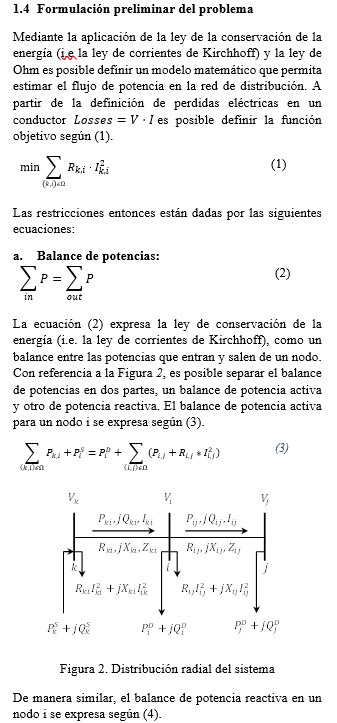

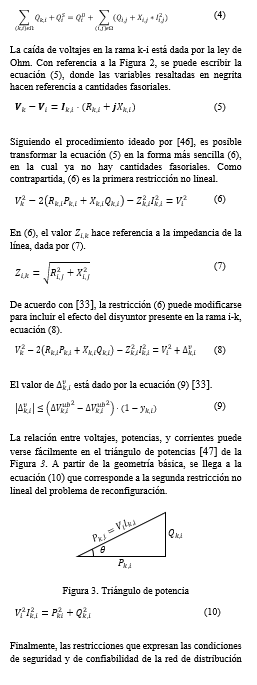

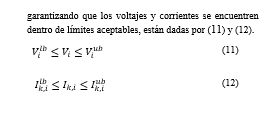

In [3]:
#Vamos creando aqui la clase
class DistributionNetwork():
    def __init__(self,ruta,b):
        self.b=b#parametro de tunning restriccion cespedes.
        self.ruta=ruta
        file=open(self.ruta)#abre el archivo
        datos=file.readlines()#lee el contenido del archivo
        file.close()#cierra el archivo
        #Ahora determinamos los inicios y finales de las tablas de ramas y potencias:
        #primero declaramos algunas variables utiles:
        nodo_ref=0
        index_inicio_ramas=0
        index_final_ramas=0
        index_inicio_potencias=0
        index_final_potencias=0
        datos_ramas=[]
        datos_potencias=[]
        
        #determinamos el inicio y final de la tabla de ramas:
        for index, line in enumerate(datos):#Hallamos el inicio y el final de la tabla de datos de la red
            if line.startswith("ramos = ["):
                index_inicio_ramas=index
                print(index_inicio_ramas)
            if line.endswith("];\n"):
                index_final_ramas=index
                print(index_final_ramas)
                break
        #determinamos el inicio y final de la tabla de potencias:
        for index, line in enumerate(datos):#Hallamos el inicio y el final de la tabla de datos de potencia
            if line.startswith("barras"):
                index_inicio_potencias=index
                print(index_inicio_potencias)
            if (line.endswith("];\n")| line.endswith("];")) and index_inicio_potencias!=0:
                index_final_potencias=index
                print(index_final_potencias)
                break
        print(index_inicio_ramas)
        #Ahora si, extraemos todos los datos necesarios del archivo:
        for index, line in enumerate(datos):#itera sobre cada una de las lineas de datos
            if line.startswith("""% Datos globales"""):
                self.nodo_ref=int(re.findall('\d{1,3}',datos[index+1])[0])#almacena el atributo nodo de referencia
                self.v_ref=float(re.findall('\d{1,2}\.\d{1,2}',datos[index+2])[0])#almacena el atributo voltaje de referencia
                self.v_base=float(re.findall('\d{1,2}\.\d{1,2}',datos[index+3])[0])*1000#almacena el atributo voltaje base
                self.s_base=float(re.findall('\d+',datos[index+4])[0])*1000#almacena el atributo potencia aparente base
                self.tol=float(re.findall('\d{1,2}\^\-\d{1}',
                                          datos[index+5])[0][0:2])**float(re.findall('\d{1,2}\^\-\d{1}',
                                                                                    datos[index+5])[0][3:5])#almacena el atributo tolerancia
                #self.v_min=float(re.findall('\d{1,2}\.\d{1,2}',datos[index+6])[0])#almacena el atributo voltaje minimo
                self.v_min=0
                
                #self.v_max=float(re.findall('\d{1,2}\.\d{1,2}',datos[index+7])[0])#almacena el atributo voltaje_maximo
                self.v_max=1
                #self.v_max=1.5
                self.z_base=self.v_base**2/self.s_base#calcula la impedancia base a partir de la ley de ohm
                self.i_max=5
                #extraemos los datos de las ramas:
            if index>=index_inicio_ramas and index<=index_final_ramas:#extraemos los datos de las ramas
                nodos=re.findall("\d{1,3}",line)
                impedancia=re.findall("\d{1,3}\.\d{1,7}",line)
                datos_ramas.append([nodos[0],nodos[1],impedancia[0],impedancia[1]])
            #extrae los datos de las potencias
            if index>=index_inicio_potencias and index<=index_final_potencias:
                lista_re=re.findall("\d+\.*\d*",line)
                datos_potencias.append([lista_re[0],lista_re[1],lista_re[2],lista_re[3]])
            #creamos dos dataframes:
            #print(datos_ramas)
            self.ramas=pd.DataFrame(datos_ramas,columns=["nodo_i","nodo_j","R","X"])#creamos los dataframes de ramas y potencias
            self.potencias=pd.DataFrame(datos_potencias,columns=["nodo","Pd","Qd","Qbc"])
            #Ajustamos el tipo de dato de todas las columnas a ser float64
            self.potencias.nodo=self.potencias.nodo.astype("float")
            self.potencias.Pd=self.potencias.Pd.astype("float")*1000
            self.potencias.Qd=self.potencias.Qd.astype("float")*1000
            self.potencias.Qbc=self.potencias.Qbc.astype("float")*1000
            self.ramas.nodo_i= self.ramas.nodo_i.astype("float")
            self.ramas.nodo_j= self.ramas.nodo_j.astype("float")
            self.ramas.R= self.ramas.R.astype("float")
            self.ramas.X= self.ramas.X.astype("float")
            
            #Generamos a continuacion la red
        self.generar_red()
        #Generamos el modelo de gurobi
        self.generar_modelo_base()
        self.generar_variables_disyuntores()#Generemos la variable y_ij asociada al estado de los disyuntores
        self.generar_variables_potencia_ij()#Generamos la variable P_ij, asociada a la potencia activa de i a j
        self.generar_variable_Q_ij()#Generamos la variable Q_ij asociada a la potencia reactiva de i a j
        #self.generar_variables_V_i()#Generamos la vairable V_i, asociada al voltaje del nodo i
        self.generar_variables_Vsqr_i()#Generamos la variable Vsqr, asociada al cuadrado del voltaje del nodo i
        #self.generar_variables_I_ij()#Generamos la variable I_ij, asociada a la corriente del arco i,j
        self.generar_variables_I_sqr()#Genermos la variable I_ij_sqr asociada al cuadrado de la corriente del arco ij
        self.generar_variable_delta_ij()
        #A continuación generamos las restricciones del problema
        self.generar_restriccion_corrientes_sqr()
        self.generar_restriccion_un_solo_arco_ij()
        self.generar_restriccion_triangulo_potencia()
        self.generar_restriccion_delta()
        self.generar_restriccion_Ohm()
        self.balance_reactiva()
        self.balance_activa()
        #self.modelo.addConstr(self.voltajes_sqr[14]==1)#Fijamos el voltaje de la subestacion en 1 p.u
        #self.restriccion_auxiliar()
        #Actualizar el modelo
        #Añadimos las ecuaciones de flujo ficticio:
        #self.crear_flujo_ficticio()
        #self.restricciones_flujo_ficticio()
        #self.restriccion_flujo_valido()
        #Añadimos las ecuaciones del multicomodity flow
        self.generar_lista_flujos()
        self.generar_variables_multi_comodity_flow()
        self.generar_full_set_equations_mcf()
        self.generar_restricciones_flujo_valido_mcf()
        self.modelo.update()
        #Escribir el reporte del modelo
        self.generar_reporte()
        #Optimizar
        self.optimizar()
    def generar_red(self):
        #En esta seccion generamos la red:
        self.Red=nx.DiGraph()#Creamos un elemento digraph
        #Recorremos primero la tabla de ramas:
        for element in self.ramas.itertuples():
            self.Red.add_edge(element[1],element[2])#añade el arco de i a j
            self.Red.add_edge(element[2],element[1])#añade el arco de j a i
            #Ahora añadimos la resistencia y la impedancia
            self.Red.edges[element[1],element[2]]["R"]=element[3]/self.z_base#Añadimos la resistencia al arco ij
            self.Red.edges[element[1],element[2]]["X"]=element[4]/self.z_base#Añadimos la inductancia al arco ij
            self.Red.edges[element[2],element[1]]["R"]=element[3]/self.z_base#Añadimos la resistencia al arco ij
            self.Red.edges[element[2],element[1]]["X"]=element[4]/self.z_base#Añadimos la inductancia al arco ij
        #Ahora recorremos la tabla de potencias
        for element in self.potencias.itertuples():
            self.Red.nodes[element[1]]["Pd"]=element[2]/self.s_base#Añadimos la demanda de potencia activa en el nodo
            self.Red.nodes[element[1]]["Qd"]=element[3]/self.s_base#Añadimos la demanda de potencia reactiva en el nodo
            self.Red.nodes[element[1]]["Qbc"]=element[4]/self.s_base#Añadimos el Qbc del nodo
    def graficar_red(self):
        nx.draw(self.Red, pos=nx.kamada_kawai_layout(self.Red),with_labels=True)
        plt.show()
    def generar_modelo_base(self):
        #Se crea un objeto modelo de gurobipy
        self.modelo=grb.Model(self.ruta[0:-4])
    def generar_variables_disyuntores(self):
        #En esta parte creamos la variable disyuntores 
        self.y=self.modelo.addVars(list(self.Red.edges),vtype=GRB.BINARY, name="estado_disyuntor",ub=1)
    def generar_variables_potencia_ij(self):
        self.pot=self.modelo.addVars(list(self.Red.edges),vtype=GRB.CONTINUOUS, name="potencia_activa",lb=0,ub=5)
    def generar_variable_Q_ij(self):
        self.q=self.modelo.addVars(list(self.Red.edges),vtype=GRB.CONTINUOUS, name="potencia_reactiva",lb=0,ub=5)
    def generar_variables_V_i(self):
        self.voltajes=self.modelo.addVars(list(self.Red.nodes),vtype=GRB.CONTINUOUS, name="voltaje",ub=self.v_max*self.v_base,
                                         lb=self.v_min*self.v_base)
    def generar_variables_Vsqr_i(self):
        self.voltajes_sqr=self.modelo.addVars(list(self.Red.nodes),vtype=GRB.CONTINUOUS, name="voltaje_sqr",
                                              lb=(self.v_min)**2,
                                              
                                              ub=(self.v_max)**2)
    def generar_variables_I_ij(self):
        self.corrientes=self.modelo.addVars(list(self.Red.edges),vtype=GRB.CONTINUOUS, name="corriente",ub=self.i_max)
    def generar_variables_I_sqr(self):
        lista_resistencias=[element[2]["R"] for element in self.Red.edges.data()]#Generamos una lista con las resistencias de los arcos
        self.corrientes_sqr=self.modelo.addVars(list(self.Red.edges),vtype=GRB.CONTINUOUS, name="corriente_sqr",
                                                obj=lista_resistencias,lb=0,ub=self.i_max**2)
    def generar_variable_delta_ij(self):
        b_abs=abs(self.v_max-self.v_min)
        self.delta=self.modelo.addVars(list(self.Red.edges),vtype=GRB.CONTINUOUS,name="delta",lb=-b_abs,ub=b_abs)
    def generar_reporte(self):
        self.modelo.write("reporte.lp")
        print("model written!!")
    def generar_restriccion_corrientes_sqr(self):
        #Esta función genera la restricción I_sqr<=I_ij**2
        for row in self.ramas.itertuples():#iteramos sobre el dataframe de ramas
            nodo_i=row[1]
            nodo_j=row[2]
            self.modelo.addConstr(self.corrientes_sqr[(nodo_i,nodo_j)]<=self.y[(nodo_i,nodo_j)]*self.i_max**2)#Restriccion del
            #arco ij
            self.modelo.addConstr(self.corrientes_sqr[(nodo_j,nodo_i)]<=self.y[(nodo_j,nodo_i)]*self.i_max**2)#Restriccion del
            #arco ij
    def generar_restriccion_un_solo_arco_ij(self):
        #Esta funcion genera la restriccion y_ij+y_ji=1
      
        self.modelo.addConstr(grb.quicksum(self.y[edge] for edge in self.Red.edges())==len(self.Red.nodes())-1)
        for element in self.ramas.itertuples():
            nodo_i=element[1]
            nodo_j=element[2]
            self.modelo.addConstr(self.y[(nodo_i,nodo_j)]+self.y[(nodo_j,nodo_i)]<=1)
        #for nodo in self.Red.nodes:
            
         #   if nodo!=self.nodo_ref:
                
          #      self.modelo.addConstr(self.y.sum('*',nodo)==1)
               
           # else:
            #    self.modelo.addConstr(self.y.sum(nodo,'*')>=1)
        
        
            
    def generar_restriccion_triangulo_potencia(self):#Genera la restriccion P**2+Q**2=S**2
        for edge in self.Red.edges():
            nodo_j=edge[1]
            self.modelo.addConstr(self.voltajes_sqr[nodo_j]*self.corrientes_sqr[edge]>=(self.pot[edge])**2+(self.q[edge])**2)
    def generar_restriccion_delta(self):
        for edge in self.Red.edges():
            self.modelo.addConstr(self.b*(1-self.y[edge])>=self.delta[edge])#b*(1-y_ij)>=delta_ij
            self.modelo.addConstr(-self.b*(1-self.y[edge])<=self.delta[edge])#delta_ij>=-b*(1-y_ij)
    def generar_restriccion_Ohm(self):#Genera la restriccion de cespedes
        for edge in self.Red.edges():#Recorremos cada rama
            #Añadimos la restricción de cespedes
            nodo_i=edge[0]
            nodo_j=edge[1]
            R=self.Red.edges[edge]["R"]#Obtenemos la resistencia del arco ij
            X=self.Red.edges[edge]["X"]#Obtenemos la resistencia del arco ij
            Z_sqr=R**2+X**2#Clculamos la magnitud de la impedancia al cuadrado del arco ij
            self.modelo.addConstr(self.voltajes_sqr[nodo_i]==self.voltajes_sqr[nodo_j]+
                                  2*(R*self.pot[edge]+X*self.q[edge])-Z_sqr*self.corrientes_sqr[edge]+self.delta[edge])
    def balance_reactiva(self):#Genera la restriccion de balance de potencia reactiva
        for node in self.Red.nodes():#Iteramos sobre los nodos de la red
            if node!=self.nodo_ref:
                #Aplica para todos los nodos excepto el de referencia
                my_dict={(node,i):self.Red.edges[(node,i)]["X"] for i in self.Red.nodes() if (node,i) in self.Red.edges()}
                corrientes, coeff = grb.multidict(my_dict)#creamos un objeto multidict
                self.modelo.addConstr(self.q.sum('*',node)-self.q.sum(node,'*')-self.corrientes_sqr.prod(coeff,node,'*')==
                                      self.Red.nodes[node]["Qd"])#Creamos la restriccion de balance de potencia reactiva
            else:#Este caso solo aplica para los nodos subestación
                my_dict={(node,i):self.Red.edges[(node,i)]["X"] for i in self.Red.nodes() if (node,i) in self.Red.edges()}
                corrientes, coeff = grb.multidict(my_dict)#creamos un objeto multidict
                self.modelo.addConstr(self.q.sum('*',node)-self.q.sum(node,'*')-self.corrientes_sqr.prod(coeff,node,'*')<=
                                      -sum(self.potencias.Qd)/self.s_base)#Creamos la restriccion de balance de potencia reactiva
    def balance_activa(self):#Genera la restriccion de balance de potencia activa
        for node in self.Red.nodes():#Iteramos sobre los nodos de la red
            if node!=self.nodo_ref:#esta condición aplica para todos los nodos que no son subestacion
                my_dict={(node,i):self.Red.edges[(node,i)]["R"] for i in self.Red.nodes() if (node,i) in self.Red.edges()}
                corrientes, coef = grb.multidict(my_dict)#creamos un objeto multidict
                self.modelo.addConstr(self.pot.sum('*',node)-self.pot.sum(node,'*')-self.corrientes_sqr.prod(coef,node,'*')==
                                    self.Red.nodes[node]["Pd"])#Añade la restricción de flujo de activa
            else:#Este caso solo aplica para los nodos subestacion
                my_dict={(node,i):self.Red.edges[(node,i)]["R"] for i in self.Red.nodes() if (node,i) in self.Red.edges()}
                corrientes, coef = grb.multidict(my_dict)#creamos un objeto multidict
                self.modelo.addConstr(self.pot.sum('*',node)-self.pot.sum(node,'*')-self.corrientes_sqr.prod(coef,node,'*')<=
                                    -sum(self.potencias.Pd)/self.s_base)
    def restriccion_auxiliar(self):#Esta no sirvio!
        for node in self.Red.nodes():#Iteramos sobre los nodos
            if node!=self.nodo_ref:#Para todos los nodos esxcepto el de referencia
                self.modelo.addConstr(self.y.sum('*',node)==1)
                R=self.Red.predecessors(node)
                #maxVarsList=[self.y[node,element] for elemen in R]
                #self.modelo.addGenConstrMax(1, maxVarsList, name='maxconstr_')
                #"self.modelo.addConstr(1==grb.max_(self.y[element,node] for element in R))
                self.modelo.addConstr((self.y.sum('*',node))**2-2*self.y.sum('*',node)<=-1)
                #R=self.Red.predecessors(node)
                #self.modelo.addConstr(grb.quicksum(self.y[r,node]**2 for r in R)<=1)
            else:#el nodo ref
                #self.modelo.addConstr(self.y.sum(node,'*')==3)
                pass
    def optimizar(self):
        #self.modelo.params.NonConvex = 2
        start=time()
        self.modelo.optimize()
        self.tiempo_computo=time()-start
        if self.modelo.Status == grb.GRB.INFEASIBLE:
            self.modelo.computeIIS()
            self.modelo.write('iismodel.ilp')
    def get_red_opti(self):
        self.red_optima=nx.Graph()
        for element in self.y:
            if round(self.y[element].x)==1:
                self.red_optima.add_edge(element[0],element[1])
        nx.draw(self.red_optima, pos=nx.kamada_kawai_layout(self.red_optima),with_labels=True)
        plt.show()
    #Codigo para el single comodity flow:
    def crear_flujo_ficticio(self):
        self.f=self.modelo.addVars(list(self.Red.edges),vtype=GRB.CONTINUOUS, name="f",ub=len(self.Red.nodes)-1)
    def restricciones_flujo_ficticio(self):
        for nodo in self.Red.nodes:
            if nodo!=self.nodo_ref:#Para todos los nodos excepto la subestacion
                self.modelo.addConstr(self.f.sum("*",nodo)==self.f.sum(nodo,"*")+1,name=f"balance_flujo_ficticio_nodo_{nodo}")
            else:#nodos subestacion:
                self.modelo.addConstr(self.f.sum(nodo,"*")==len(self.Red.nodes)-1,
                                      name="balance_flujo_ficticio_subestacion_parte1")
                self.modelo.addConstr(self.f.sum("*",nodo)==0,
                                      name="balance_flujo_ficticio_subestacion_parte2")
    def restriccion_flujo_valido(self):
        for edge in self.Red.edges:
            self.modelo.addConstr(self.f[edge]<=(len(self.Red.nodes)-1)*self.y[edge],name=f"solo_flujo_por_edge_{edge}_activo")
    #Codigo para el multi_comodity_flow
    def generar_lista_flujos(self):#Genera la lista de los flujos f_i,j,k necesarios
        self.lista_flujos_mcf=[]
        for nodo in self.Red.nodes:
            if nodo!=self.nodo_ref:
                for edge in self.Red.edges():
                    i=edge[0]
                    j=edge[1]
                    self.lista_flujos_mcf.append((i,j,nodo))
    def generar_variables_multi_comodity_flow(self):
        self.f_mc=self.modelo.addVars(self.lista_flujos_mcf,vtype=GRB.CONTINUOUS, name="f_mc",ub=1)
    def generar_ecuaciones_balance_mc(self,k):#el parametro k se refiere al comodity k
        for nodo in self.Red.nodes:
            if nodo!=self.nodo_ref:#Para todos los nodos excepto la subestacion
                if nodo!=k:#para todos los nodos que no son el destino:
                    self.modelo.addConstr(self.f_mc.sum("*",nodo,k)==self.f_mc.sum(nodo,"*",k),
                                          name=f"balance_flujo_ficticio_nodo_{nodo}_comodity_{k}")
                else:#si el nodo es el destino:
                    self.modelo.addConstr(self.f_mc.sum("*",nodo,k)==self.f_mc.sum(nodo,"*",k)+1,
                                          name=f"balance_flujo_ficticio_nodo_{nodo}_comodity_{k}")
            else:#nodos subestacion:
                self.modelo.addConstr(self.f_mc.sum(nodo,"*",k)==1,
                                      name=f"balance_flujo_ficticio_subestacion_comodity_{k}_parte_1")
                self.modelo.addConstr(self.f_mc.sum("*",nodo,k)==0,
                                      name=f"balance_flujo_ficticio_subestacion_comodity_{k}_parte_2")
    def generar_full_set_equations_mcf(self):
        for nodo in self.Red.nodes:
            if nodo!=self.nodo_ref:
                self.generar_ecuaciones_balance_mc(nodo)
    def generar_restricciones_flujo_valido_mcf(self):
        
        for element in self.lista_flujos_mcf:
            
            self.modelo.addConstr(self.f_mc[element]<=1*self.y[(element[0],element[1])],
                                  name=f"restriccion_flujo_valido_comodity_{element[2]}_arco{(element[0],element[1])}")
                
    
                
            
       
            
    
    
        
    
        
            
            
        
            
        


In [ ]:
red_84=DistributionNetwork("datos136.txt",0.2)
#red_14.v_min=0.5
#red_14.potencias

16
171
175
310
16
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-14
model written!!
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 5 3550H with Radeon Vega Mobile Gfx, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 62292 rows, 43816 columns and 174720 nonzeros
Model fingerprint: 0x2d0c11d0
Model has 312 quadratic constraints
Variable types: 43504 continuous, 312 integer (312 binary)
Coefficient statistics:
  Matrix range     [6e-06, 3e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e-03, 2e+00]
  Bounds range     [1e+00, 3e+01]
  RHS range        [5e-06, 1e+02]
Presolve removed 39145 rows and 33872 columns
Presolve time: 0.74s
Presolved: 23147 rows, 9944 columns, 60271 nonzeros
Presolved model has 270 quadratic constraint(s)
Variable types: 9708 continuous, 236 integer (236 binary)

Root relaxation: objective 7.474718e-

   487   353     cutoff   28         0.00279    0.00265  4.94%   872  432s
   496   356    0.00269   30  154    0.00279    0.00265  4.94%   856  437s
   502   360    0.00268   31  147    0.00279    0.00265  4.94%   846  443s
   510   363    0.00269   32  145    0.00279    0.00265  4.94%   833  449s
   517   367    0.00269   33  142    0.00279    0.00265  4.94%   821  455s
   526   367     cutoff   34         0.00279    0.00265  4.94%   807  460s
   535   370    0.00270   36  121    0.00279    0.00265  4.94%   794  467s
   543   377    0.00271   37  114    0.00279    0.00265  4.94%   782  476s
   552   378     cutoff   38         0.00279    0.00265  4.94%   769  482s
   564   384    0.00272   39  101    0.00279    0.00265  4.94%   753  489s
   576   381    0.00277   41   94    0.00279    0.00265  4.94%   737  498s
   593   378     cutoff   42         0.00279    0.00265  4.94%   716  508s
   610   380    0.00265   19  209    0.00279    0.00265  4.94%   696  517s
   622   380    0.00265  

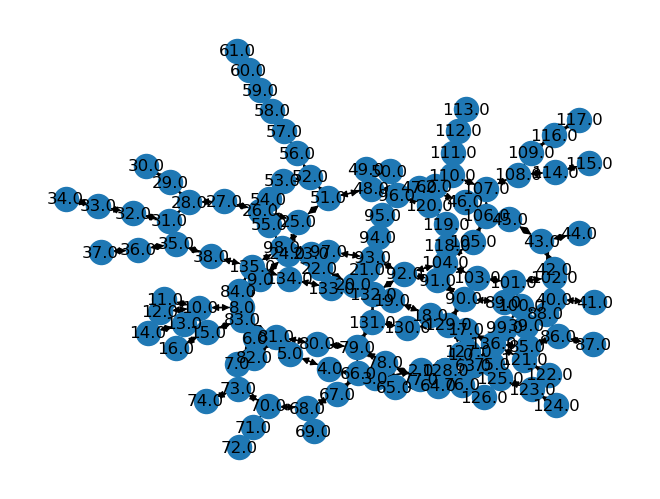

In [4]:
red_84.graficar_red()

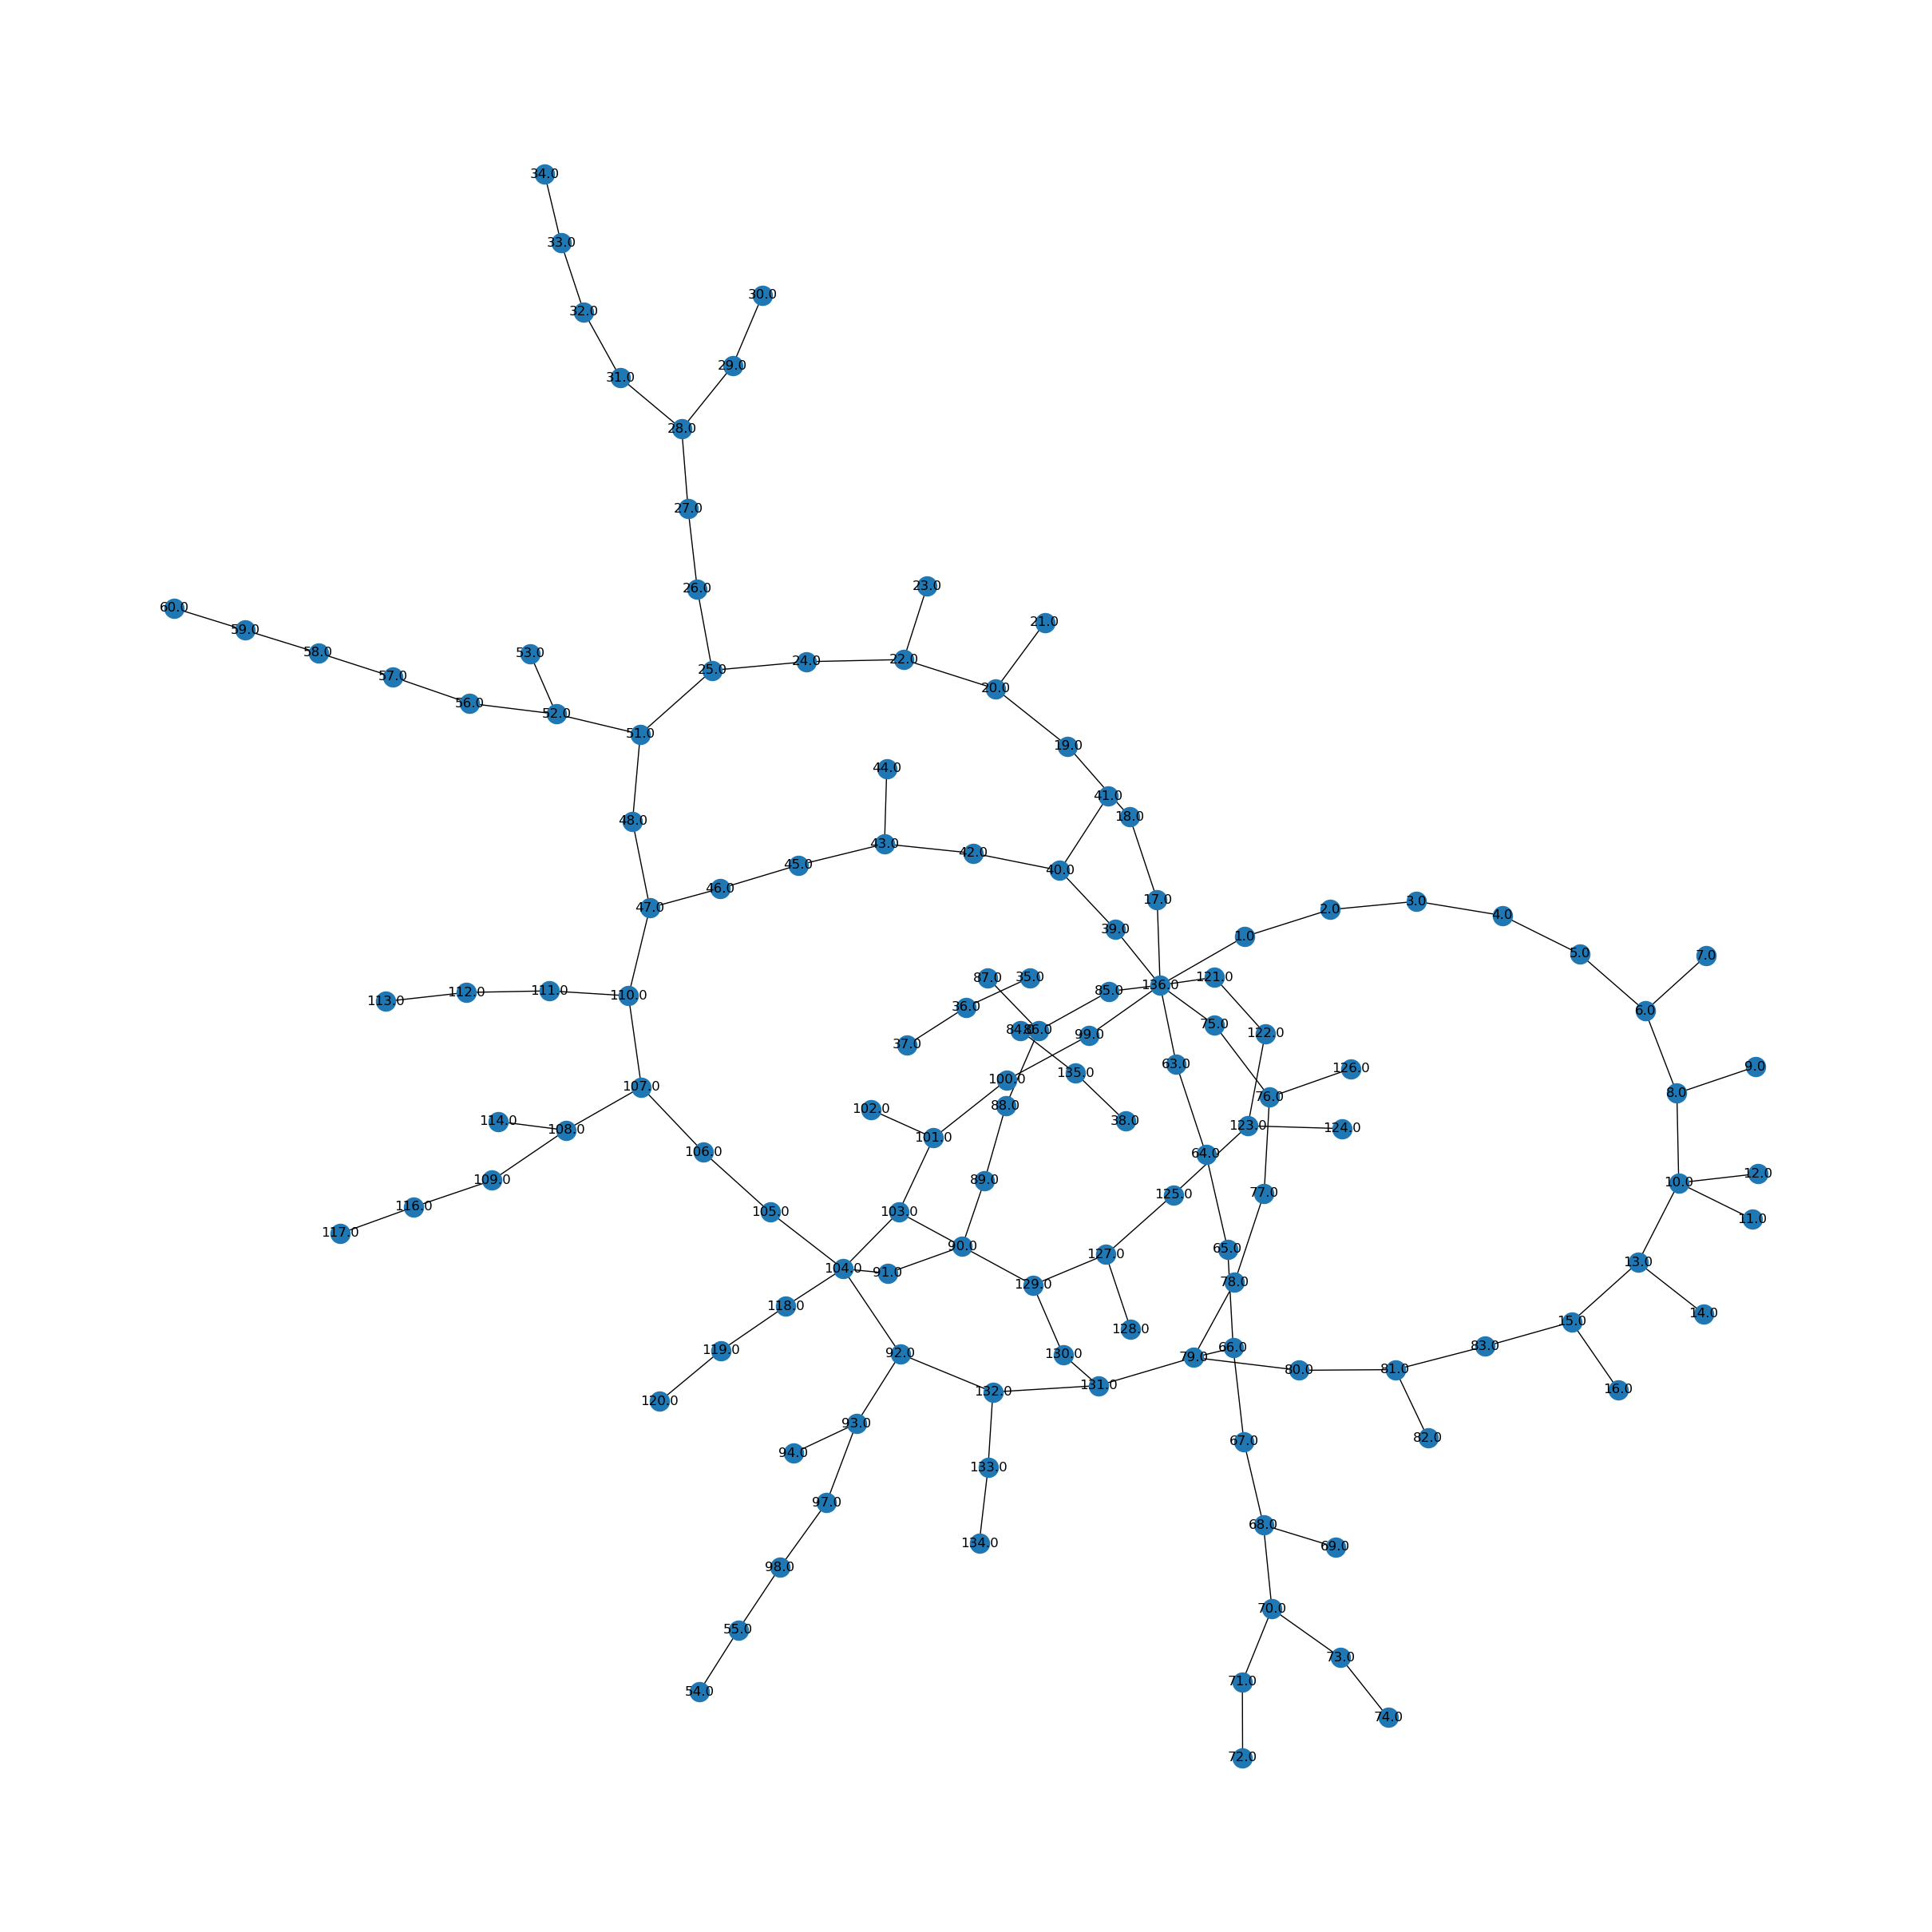

In [5]:
red_optima=nx.Graph()
for element in red_84.y:
    if round( red_84.y[element].x)==1:
        
        red_optima.add_edge(element[0],element[1])
plt.figure(3,figsize=(24,24))
nx.draw(red_optima, pos=nx.kamada_kawai_layout(red_optima),with_labels=True)

plt.show()

EN este caso podemos ver que la solución a la que converge el modelo es efectivamente un arból, cuya raiz es el nodo 14, corres-
pondiente a la subestación. A continuación se muestran los valores de las diferentes variables del modelo. 

In [6]:
for v in red_84.modelo.getVars():
    if v.x>1e-6:
        print(v.varName,v.x)

estado_disyuntor[136.0,1.0] 1.0
estado_disyuntor[136.0,17.0] 1.0
estado_disyuntor[136.0,39.0] 1.0
estado_disyuntor[136.0,63.0] 1.0
estado_disyuntor[136.0,75.0] 1.0
estado_disyuntor[136.0,85.0] 1.0
estado_disyuntor[136.0,99.0] 1.0
estado_disyuntor[136.0,121.0] 1.0
estado_disyuntor[1.0,2.0] 1.0
estado_disyuntor[2.0,3.0] 1.0
estado_disyuntor[3.0,4.0] 1.0
estado_disyuntor[4.0,5.0] 1.0
estado_disyuntor[5.0,6.0] 1.0
estado_disyuntor[6.0,7.0] 1.0
estado_disyuntor[6.0,8.0] 1.0
estado_disyuntor[7.0,73.0] 1.0
estado_disyuntor[8.0,9.0] 1.0
estado_disyuntor[8.0,10.0] 1.0
estado_disyuntor[10.0,11.0] 1.0
estado_disyuntor[10.0,12.0] 1.0
estado_disyuntor[10.0,13.0] 1.0
estado_disyuntor[13.0,14.0] 1.0
estado_disyuntor[13.0,15.0] 1.0
estado_disyuntor[15.0,16.0] 1.0
estado_disyuntor[17.0,18.0] 1.0
estado_disyuntor[18.0,19.0] 1.0
estado_disyuntor[19.0,20.0] 1.0
estado_disyuntor[20.0,21.0] 1.0
estado_disyuntor[20.0,22.0] 1.0
estado_disyuntor[22.0,23.0] 1.0
estado_disyuntor[22.0,24.0] 1.0
estado_disyuntor[2

In [7]:
red_84.tiempo_computo

425.4304881095886